# Load data from csv files

In [1]:
import pandas as pd

In [2]:
# Read data from csv files
label = pd.read_csv('BurnedArea-100k.csv')
elevation = pd.read_csv('Elevation-100k.csv')
forest = pd.read_csv('Forest-100k.csv')
humanMod = pd.read_csv('HumanModification-100k.csv')
leaf = pd.read_csv('LeafArea-100k.csv')
rain = pd.read_csv('Precipitation-100k.csv')
radiation = pd.read_csv('Radiation-100k.csv')
soil = pd.read_csv('SoilType-100k.csv')
temp = pd.read_csv('Temperature-100k.csv')

In [7]:
elevation.head()

,system:index,elevation
0,0_0,922
1,1_0,14
2,3_0,939
3,4_0,1911
4,5_0,295


In [3]:
# Merge all dataframes via inner join
samples = pd.merge(left=elevation, right=forest, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=humanMod, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=leaf, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=rain, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=radiation, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=soil, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=temp, left_on='system:index', right_on='system:index')

In [4]:
fireIdx = label.copy()
del fireIdx['BurnDate']
del fireIdx['FirstDay']
del fireIdx['LastDay']
del fireIdx['QA']
del fireIdx['BurnMonth']
fireIdx.head()

,system:index,Uncertainty
0,145_0,2
1,149_0,2
2,188_0,3
3,203_0,1
4,416_0,3


In [5]:
# Label samples
samplesCopy = samples.copy()
samplesCopy = pd.merge(left=fireIdx, right=samplesCopy, how='right', left_on='system:index', right_on='system:index')

sampleLabel = samplesCopy['Uncertainty'].fillna(100).tolist()
firstNoFireIdx = sampleLabel.index(100)

# Drop label column
del samplesCopy['Uncertainty']
print(len(samplesCopy.columns))
samplesList = samplesCopy.values.tolist()
fireSamples = samplesList[:firstNoFireIdx]
fireUncertain = sampleLabel[:firstNoFireIdx]
noFireSamples = samplesList[firstNoFireIdx:]
noFireLabel = [0 for _ in range(len(noFireSamples))]

46


In [37]:
print(len(fireLabel))
print(len(noFireLabel))

1051
79537


In [6]:
from sklearn.model_selection import train_test_split
X_fire_train, X_fire_test, y_fire_train, y_fire_test = train_test_split(fireSamples, fireUncertain, test_size=0.2, random_state=0)
X_no_fire_train, X_no_fire_test, y_no_fire_train, y_no_fire_test = train_test_split(noFireSamples, noFireLabel, test_size=0.9, random_state=42)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# Binary Classification

In [8]:
y_fire_train_fnf = [1 for _ in range(len(y_fire_train))]
y_fire_test_fnf = [1 for _ in range(len(y_fire_test))]
X_train = X_fire_train + X_no_fire_train
y_train = y_fire_train_fnf + y_no_fire_train

In [12]:
gb_fnf = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.1,max_depth=4,max_features=1.0,min_samples_leaf=3,random_state=20)
gb_fnf = gb_fnf.fit(X_train, y_train)
y_fire_pred_msk = gb_fnf.predict(X_fire_test)
np.mean(y_fire_test_fnf == y_fire_pred_msk)

0.8151658767772512

In [13]:
y_no_fire_pred = gb_fnf.predict(X_no_fire_test)
np.mean(y_no_fire_pred == y_no_fire_test)

0.9904168529280286

# Hyperparamters Adjust to avoid outfit

In [10]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]}
est = GradientBoostingClassifier(n_estimators=3000)
gs_cv = GridSearchCV(est, param_grid, cv=5).fit(X_train, y_train)
# Pinrt out the best parameters
gs_cv.best_params_

# Set n_estimators to higher value and tune again

KeyboardInterrupt: 

# Confusion Matrix for Binary Classification

In [ ]:
yy_test = y_fire_test + y_no_fire_test
#rint(yy_test)
print(type(y_fire_pred))
yy_pred = np.append(y_fire_pred, y_no_fire_pred)
cm = confusion_matrix(yy_test, yy_pred)

# Only uses the labels that appear in the data
labels = unique_labels(yy_test, yy_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

In [118]:
y_no_fire_pred = rf.predict(X_no_fire_test)
np.mean(y_no_fire_pred == y_no_fire_test)

#print(y_fire_pred)
#print(y_no_fire_test)
#print(y_no_fire_pred)
#print(np.mean((y_no_fire_pred + y_fire_pred) == (y_no_fire_test + y_fire_pred)))

0.9921770227983907

# Multi-Classification

In [14]:
gb_risk = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.1,max_depth=4,max_features=1.0,min_samples_leaf=3,random_state=20)
gb_risk = gb_risk.fit(X_fire_train, y_fire_train)
y_pred_fire_risk = gb_risk.predict(X_fire_test)
print(np.mean((y_fire_test == y_pred_fire_risk) * y_fire_pred_msk))
#np.mean(result)

0.35545023696682465


NameError: name 'y_fire_pred_risk' is not defined

In [22]:
result = []
for i, true_val in enumerate(y_fire_test):
    if abs(true_val - y_pred_fire_risk[i]) < 4:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_fire_pred_msk))

0.7203791469194313


# Confusion Matrix for Multi-Classification

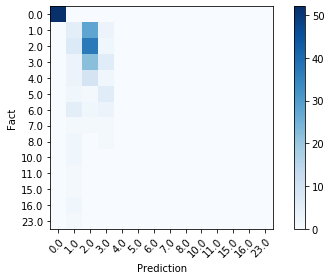

In [201]:
y_test_multi = y_fire_test * y_fire_pred_msk
y_pred_multi = y_fire_pred_multi * y_fire_pred_msk
cm = confusion_matrix(y_test_multi, y_pred_multi)

# Only uses the labels that appear in the data
labels = unique_labels(y_test_multi, y_pred_multi)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

# Metrics

In [120]:
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71584
           1       0.22      0.75      0.34       211

    accuracy                           0.99     71795
   macro avg       0.61      0.87      0.67     71795
weighted avg       1.00      0.99      0.99     71795

